In [1]:
url = ("http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/"
       "latest/Bight_gcmplt.nc")

In [2]:
from netCDF4 import Dataset

from odvc import get_formula_terms_variables


nc = Dataset(url)

var = get_formula_terms_variables(nc)

var

[<type 'netCDF4._netCDF4.Variable'>
 float32 sigma(sigma)
     long_name: stretched vertical coordinate levels
     units: 1
     positive: up
     standard_name: ocean_sigma_coordinate
     formula_terms: sigma: sigma eta: elev depth: depth
     axis: Z
 unlimited dimensions: 
 current shape = (11,)
 filling off]

In [3]:
from odvc import get_formula_terms

formula_terms = get_formula_terms(var[0])

formula_terms

OrderedDict([(u'sigma', u'sigma'), (u'eta', u'elev'), (u'depth', u'depth')])

In [4]:
from odvc import get_formula_terms_dims


dims = get_formula_terms_dims(nc, formula_terms)

dims

OrderedDict([(u'sigma', (u'sigma',)),
             (u'eta', (u'time', u'ypos', u'xpos')),
             (u'depth', (u'ypos', u'xpos'))])

In [5]:
from odvc import z_shape

new_shape = z_shape(nc, dims)

new_shape

(288, 11, 22, 124)

In [6]:
from odvc import prepare_arrays


arrays = prepare_arrays(nc, formula_terms, new_shape)

arrays

{u'depth': dask.array<getitem..., shape=(1, 1, 22, 124), dtype=float32, chunksize=(1, 1, 22, 124)>,
 u'eta': dask.array<getitem..., shape=(288, 1, 22, 124), dtype=int16, chunksize=(1, 1, 22, 124)>,
 u'sigma': dask.array<getitem..., shape=(1, 11, 1, 1), dtype=float32, chunksize=(1, 11, 1, 1)>}

In [7]:
[(var, arr.shape) for var, arr in arrays.items()]

[(u'depth', (1, 1, 22, 124)),
 (u'eta', (288, 1, 22, 124)),
 (u'sigma', (1, 11, 1, 1))]

In [8]:
 from odvc import ocean_sigma_coordinate

z = ocean_sigma_coordinate(arrays['sigma'],
                           arrays['eta'],
                           arrays['depth'])

print(z.shape)

(288, 11, 22, 124)


In [9]:
salt = nc.get_variables_by_attributes(standard_name='sea_water_salinity')[0]
temp = nc.get_variables_by_attributes(standard_name='sea_water_temperature')[0]

s = salt[-1, :, 0, 0]
t = temp[-1, :, 0, 0]
p = z[-1, :, 0, 0]

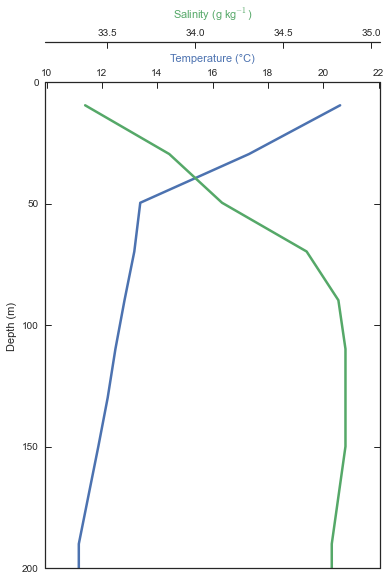

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

import seaborn
seaborn.set(style='ticks')


def adjust_xlim(ax, offset):
    x1, x2 = ax.get_xlim()
    ax.set_xlim(x1 - offset, x2 + offset)


fig = plt.figure(figsize=(6, 9))
fig.subplots_adjust(bottom=0.1, top=0.85)
ax0 = host_subplot(111, axes_class=AA.Axes)

ax0.invert_yaxis()
ax1 = ax0.twiny()

new_axis0 = ax0.get_grid_helper().new_fixed_axis
new_axis1 = ax1.get_grid_helper().new_fixed_axis

ax0.axis["top"] = new_axis0(loc="top", axes=ax0, offset=(0, 0))
ax1.axis["top"] = new_axis1(loc="top", axes=ax1, offset=(0, 40))

ax0.axis["bottom"].toggle(all=False)
ax1.axis["bottom"].toggle(all=False)

ax0.set_ylabel("Depth (m)")
ax0.set_xlabel(u"Temperature (\xb0C)")
ax1.set_xlabel(r"Salinity (g kg$^{-1}$)")

kw = dict(linewidth=2.5)
l0, = ax0.plot(t, -p, **kw)
l1, = ax1.plot(s, -p, **kw)

adjust_xlim(ax0, offset=0.05)
adjust_xlim(ax1, offset=0.05)

ax0.axis["top"].label.set_color(l0.get_color())
ax1.axis["top"].label.set_color(l1.get_color())